# 02 — Regression Homework

My notes and code for the car fuel efficiency homework.
I'm keeping it simple and following the course flow.
The CSV file is in the same folder as this notebook.


In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

In [12]:
# config
DATA_FILE = 'car_fuel_efficiency.csv'
FEATURES = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
TARGET = 'fuel_efficiency_mpg'

df = pd.read_csv(DATA_FILE)
df = df[FEATURES + [TARGET]].copy()
df.head()


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## EDA
Quick look at the target to see its range and shape.


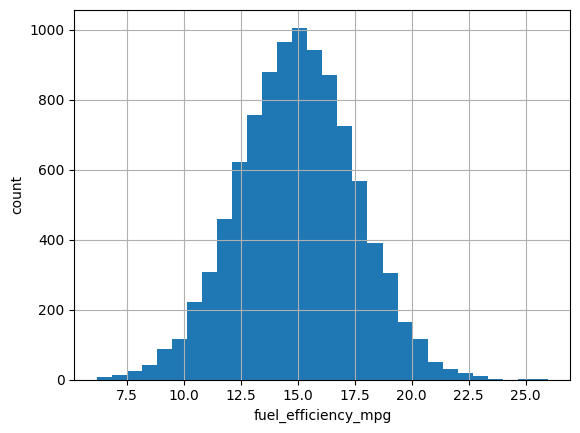

In [13]:
df[TARGET].describe()

ax = df[TARGET].hist(bins=30)
ax.set_xlabel(TARGET); ax.set_ylabel('count');


## Q1 and Q2 — quick checks
Find which feature has missing values and the median horsepower.


In [14]:
# Q1: which feature has missing values?
missing_counts = df[FEATURES].isna().sum()
print('Missing values per feature:')
print(missing_counts.to_string())
missing_cols = [c for c, v in missing_counts.items() if v > 0]
if missing_cols:
    print('Columns with missing values:', ', '.join(missing_cols))
else:
    print('No missing values in selected features')

# Q2: horsepower median
hp_median = float(df['horsepower'].median())
print('Median horsepower:', hp_median)


Missing values per feature:
engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
Columns with missing values: horsepower
Median horsepower: 149.0


## Split (train/val/test 60/20/20)
I shuffle with a fixed seed for reproducibility, then split 60/20/20 into train/val/test.


In [15]:
def split_df(df, seed=42):
    np.random.seed(seed)
    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)
    return df_train, df_val, df_test

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def prepare_X(df, fill_value=0.0):
    X = df[FEATURES].copy()
    X = X.fillna(fill_value)
    return X.values

df_train, df_val, df_test = split_df(df, seed=42)
y_train = df_train[TARGET].values
y_val = df_val[TARGET].values
y_test = df_test[TARGET].values
len(df_train), len(df_val), len(df_test)


(5822, 1940, 1942)

## Q3: Missing values — 0 vs mean
Try two simple imputations (0 vs train mean) and compare validation RMSE.


In [16]:
# fill with 0
X_train_0 = prepare_X(df_train, fill_value=0)
X_val_0 = prepare_X(df_val, fill_value=0)
lr0 = LinearRegression()
lr0.fit(X_train_0, y_train)
pred_val_0 = lr0.predict(X_val_0)
rmse_0 = rmse(y_val, pred_val_0)
print('RMSE (0):', round(rmse_0, 2))

# fill with mean (from train)
means = df_train[FEATURES].mean()
X_train_m = df_train[FEATURES].fillna(means).values
X_val_m = df_val[FEATURES].fillna(means).values
lr_m = LinearRegression()
lr_m.fit(X_train_m, y_train)
pred_val_m = lr_m.predict(X_val_m)
rmse_m = rmse(y_val, pred_val_m)
print('RMSE (mean):', round(rmse_m, 2))

print('Better:', '0' if rmse_0 < rmse_m else 'mean' if rmse_m < rmse_0 else 'same')


RMSE (0): 0.52
RMSE (mean): 0.46
Better: mean


## Q4: Regularized linear regression (Ridge)
Try a few `r` values for Ridge (0 = plain LinearRegression) and check val RMSE.


In [17]:
rs = [0, 0.01, 0.1, 1, 5, 10, 100]
scores = []
X_train = prepare_X(df_train, fill_value=0)
X_val = prepare_X(df_val, fill_value=0)
for r in rs:
    if r == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    p = model.predict(X_val)
    s = rmse(y_val, p)
    print(r, round(s, 2))
    scores.append(s)
best_r = rs[int(np.argmin(scores))]
print('Best r:', best_r)


0 0.52
0.01 0.52
0.1 0.52
1 0.52
5 0.52
10 0.52
100 0.52
Best r: 0


## Q5: Seeds and score stability
Repeat the split with seeds 0..9, train LR with NA=0, collect val RMSEs and check std.


In [18]:
rmses = []
for seed in range(10):
    dtr, dval, _ = split_df(df, seed=seed)
    ytr = dtr[TARGET].values
    yv = dval[TARGET].values
    Xtr = prepare_X(dtr, fill_value=0)
    Xv = prepare_X(dval, fill_value=0)
    m = LinearRegression()
    m.fit(Xtr, ytr)
    pv = m.predict(Xv)
    rmses.append(rmse(yv, pv))
print('RMSEs:', [round(x, 3) for x in rmses])
print('std:', round(float(np.std(rmses)), 3))


RMSEs: [0.521, 0.522, 0.523, 0.516, 0.511, 0.529, 0.532, 0.51, 0.515, 0.513]
std: 0.007


## Q6: Final model
Use seed 9, train on train+val with Ridge (r=0.001), then report test RMSE.


In [19]:
df_train, df_val, df_test = split_df(df, seed=9)
df_full = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full = df_full[TARGET].values
y_t = df_test[TARGET].values
X_full = prepare_X(df_full, fill_value=0)
X_t = prepare_X(df_test, fill_value=0)
final = Ridge(alpha=0.001)
final.fit(X_full, y_full)
pt = final.predict(X_t)
print('Test RMSE:', round(rmse(y_t, pt), 3))


Test RMSE: 0.515
